In [1]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.11.0
Torchvision Version:  0.12.0


In [2]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
data_dir = "./../Picture_resize"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "squeezenet"

# Number of classes in the dataset
num_classes = 2

# Batch size for training (change depending on how much memory you have)
batch_size = 8

# Number of epochs to train for
num_epochs = 15

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

In [3]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [4]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [5]:
#(fc): nn.Linear(in_features=512, out_features=1000, bias=True)

In [6]:
#model.fc = nn.Linear(512, num_classes)

In [7]:
#model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))

In [8]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

In [9]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


In [10]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 classifier.1.weight
	 classifier.1.bias


In [11]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/14
----------


C:\Users\H3rb\anaconda3\envs\NeRF\lib\site-packages\torch\nn\functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


train Loss: 0.8313 Acc: 0.4362
val Loss: 0.7105 Acc: 0.5581

Epoch 1/14
----------
train Loss: 0.6429 Acc: 0.6064
val Loss: 0.6614 Acc: 0.5581

Epoch 2/14
----------
train Loss: 0.4780 Acc: 0.7979
val Loss: 0.7243 Acc: 0.5349

Epoch 3/14
----------
train Loss: 0.3684 Acc: 0.8723
val Loss: 0.7860 Acc: 0.5116

Epoch 4/14
----------
train Loss: 0.3837 Acc: 0.8298
val Loss: 1.0067 Acc: 0.5116

Epoch 5/14
----------
train Loss: 0.2133 Acc: 0.9043
val Loss: 0.6576 Acc: 0.6279

Epoch 6/14
----------
train Loss: 0.1865 Acc: 0.9255
val Loss: 0.6335 Acc: 0.6744

Epoch 7/14
----------
train Loss: 0.1485 Acc: 0.9468
val Loss: 0.9296 Acc: 0.6512

Epoch 8/14
----------
train Loss: 0.1536 Acc: 0.9149
val Loss: 0.6533 Acc: 0.7674

Epoch 9/14
----------
train Loss: 0.0817 Acc: 0.9894
val Loss: 0.5188 Acc: 0.6977

Epoch 10/14
----------
train Loss: 0.1305 Acc: 0.9574
val Loss: 0.6545 Acc: 0.7674

Epoch 11/14
----------
train Loss: 0.0894 Acc: 0.9787
val Loss: 0.6924 Acc: 0.7674

Epoch 12/14
----------
t

Epoch 0/14
----------
train Loss: 0.7226 Acc: 0.5532
val Loss: 0.6929 Acc: 0.5581

Epoch 1/14
----------
train Loss: 0.6948 Acc: 0.4574
val Loss: 0.6933 Acc: 0.4419

Epoch 2/14
----------
train Loss: 0.6939 Acc: 0.4574
val Loss: 0.6931 Acc: 0.4419

Epoch 3/14
----------
train Loss: 0.6933 Acc: 0.4574
val Loss: 0.6931 Acc: 0.4419

Epoch 4/14
----------
train Loss: 0.6934 Acc: 0.4574
val Loss: 0.6931 Acc: 0.4419

Epoch 5/14
----------
train Loss: 0.6932 Acc: 0.4574
val Loss: 0.6931 Acc: 0.4419

Epoch 6/14
----------
train Loss: 0.6930 Acc: 0.4574
val Loss: 0.6931 Acc: 0.4419

Epoch 7/14
----------
train Loss: 0.6931 Acc: 0.4574
val Loss: 0.6931 Acc: 0.4419

Epoch 8/14
----------
train Loss: 0.6932 Acc: 0.4574
val Loss: 0.6931 Acc: 0.4419

Epoch 9/14
----------
train Loss: 0.6932 Acc: 0.4574
val Loss: 0.6931 Acc: 0.4419

Epoch 10/14
----------
train Loss: 0.6930 Acc: 0.4574
val Loss: 0.6931 Acc: 0.4419

Epoch 11/14
----------
train Loss: 0.6931 Acc: 0.4574
val Loss: 0.6931 Acc: 0.4419

Ep

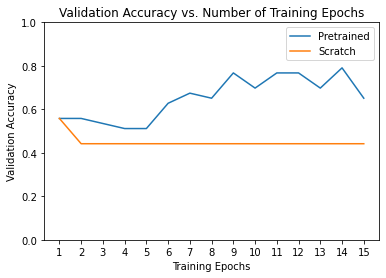

In [12]:
# Initialize the non-pretrained version of the model used for this run
scratch_model,_ = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=False)
scratch_model = scratch_model.to(device)
scratch_optimizer = optim.SGD(scratch_model.parameters(), lr=0.001, momentum=0.9)
scratch_criterion = nn.CrossEntropyLoss()
_,scratch_hist = train_model(scratch_model, dataloaders_dict, scratch_criterion, scratch_optimizer, num_epochs=num_epochs, is_inception=(model_name=="inception"))

# Plot the training curves of validation accuracy vs. number
#  of training epochs for the transfer learning method and
#  the model trained from scratch
ohist = []
shist = []

ohist = [h.cpu().numpy() for h in hist]
shist = [h.cpu().numpy() for h in scratch_hist]

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
plt.plot(range(1,num_epochs+1),shist,label="Scratch")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

In [25]:
import glob
test_dir = "./../Picture_resize"
test = glob.glob('./../Picture_resize/val/*.jpg')

In [29]:
def show_prediction(model, transform, imgs, n=3):
    for img in imgs:
        # 1. PIL Image を標準化したテンソルにする。
        # 2. バッチ次元を追加する。 (C, H, W) -> (1, C, H, W)
        # 3. 計算するデバイスに転送する。
        inputs = transform(img).unsqueeze(dim=0).to(device)

        with torch.no_grad():
            # 順伝搬を行う。
            outputs = model(inputs)

            # 確率の最も高いクラスを予測ラベルとする。
            class_id = int(outputs.argmax(dim=1)[0])

        # 推論結果を表示する。
        display.display(img.resize((224, 224)))
        print(class_names[class_id])


imgs = []
for class_dir in (test_dir/ "val").iterdir():
    for img_path in sorted(class_dir.iterdir())[:2]:
        img = Image.open(img_path)
        imgs.append(img)

show_prediction(model_ft, data_transforms["val"], imgs)

TypeError: unsupported operand type(s) for /: 'str' and 'str'